In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from src.energies.alp_energy import ALPEnergy

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
n_particles = 22
n_spatial_dim = 3
dimensionality = n_spatial_dim * n_particles
energy = ALPEnergy(
    data_path="../../data/alanine/",
    pdb_filename="../../data/pdbs/A_capped.pdb",
    n_particles=n_particles,
    spatial_dim=n_spatial_dim,
    dimensionality=dimensionality,
    temperature=600,
    device=device,
    device_index="0",
    should_normalize=True,
    data_normalization_factor=0.1641,
)

Plotting Ramachandran 0 out of 1


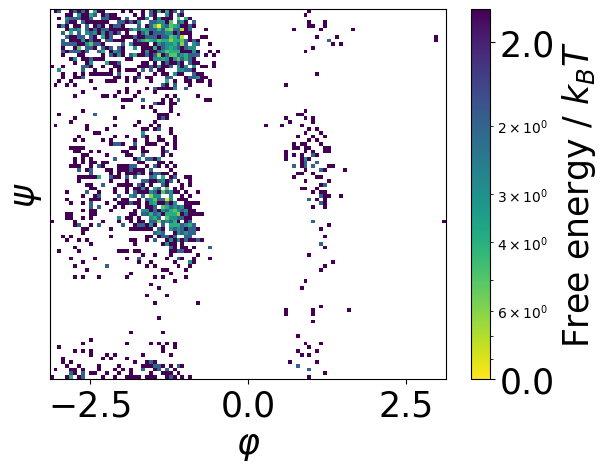

In [12]:
# high_temp_samples = torch.cat(
#     (energy.sample_train_set(10000), energy.sample_test_set(10000), energy.sample_val_set(10000)),
#     dim=0,
# )
high_temp_samples = energy.sample_train_set(2048)
energy.plot_ramachandran(high_temp_samples.detach().cpu());

In [ ]:
plt.hist(-energy(energy.sample_test_set(5000)).cpu(), bins=200, density=True, alpha=0.5);

In [ ]:
import glob
from collections import defaultdict

import numpy as np

T = 1
noise_std = 0.2

samples = defaultdict(list)


temps = [300, 400, 450, 500, 550, 600, 1200]
for temp in temps:
    print(temp)
    path = f"/network/scratch/a/alexander.tong/energy_temp/data/md/A_capped/A_capped_{temp}_100000.npz"

    try:
        samples = np.load(path)
        samples = samples["all_positions"]
        samples = samples.reshape(-1, dimensionality)
        print(f"Samples at {temp} has shape: {samples.shape}")
    except PermissionError:
        print(f"Permission error for file {path}")
        break

    idxs = np.random.permutation(samples.shape[0])
    train_idx = idxs[:10000]
    val_idx = idxs[10000:20000]
    test_idx = idxs[20000:30000]

    samples_train = samples[train_idx]
    samples_val = samples[val_idx]
    samples_test = samples[test_idx]

    # if directory does not exist, create it
    import os

    temp = temp.__float__()
    data_path = f"../../data/alanine/AL{n_particles}_temp_{temp}"
    if not os.path.exists(data_path):
        os.makedirs(data_path)
    else:
        print(f"Directory {data_path} already exists. Overwriting data.")

    np.save(data_path + f"/train_split_AL{n_particles}-10000.npy", samples_train)
    np.save(data_path + f"/val_split_AL{n_particles}-10000.npy", samples_val)
    np.save(data_path + f"/test_split_AL{n_particles}-10000.npy", samples_test)
    print(f"Saved data for temperature {temp} to {data_path}")

In [23]:
temp = 600

path = f"/network/scratch/a/alexander.tong/energy_temp/data/md/A_capped/A_capped_{temp}_100000.npz"

samples = np.load(path)
samples = samples["all_positions"][:10000]
samples = samples.reshape(-1, dimensionality)

samples_tensor = torch.from_numpy(samples).float().to(device)
print(f"Samples at {temp} has shape: {samples.shape}")

Samples at 600 has shape: (10000, 66)


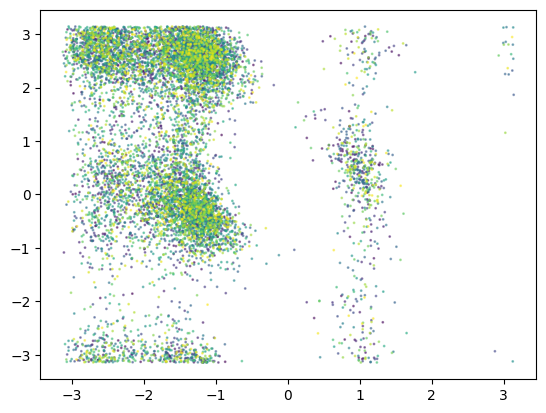

In [24]:
import mdtraj as md
import numpy as np

samples = samples.reshape(-1, energy.n_particles, energy.n_spatial_dim)
traj_samples = md.Trajectory(samples, topology=energy.topology)
phis = md.compute_phi(traj_samples)[1]
psis = md.compute_psi(traj_samples)[1]



plt.scatter(phis, psis, s=1, alpha=0.5, c=torch.arange(phis.shape[0]), cmap="viridis")